In [ ]:
!pip install ipywidgets 
!jupyter nbextension enable --py widgetsnbextension

In [3]:
import ipywidgets
from ipywidgets import IntProgress

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install --pre autogluon 

In [5]:
%matplotlib inline
import autogluon.core as ag
from autogluon.vision import ImageDataset, ImagePredictor
import pandas as pd

/usr/local/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.1+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [6]:
dataset = ImageDataset.from_folder('data/validation/')
dataset.head()

,image,label
0,/root/SageMaker-Inventory-monitoring/data/vali...,0
1,/root/SageMaker-Inventory-monitoring/data/vali...,0
2,/root/SageMaker-Inventory-monitoring/data/vali...,0
3,/root/SageMaker-Inventory-monitoring/data/vali...,0
4,/root/SageMaker-Inventory-monitoring/data/vali...,0


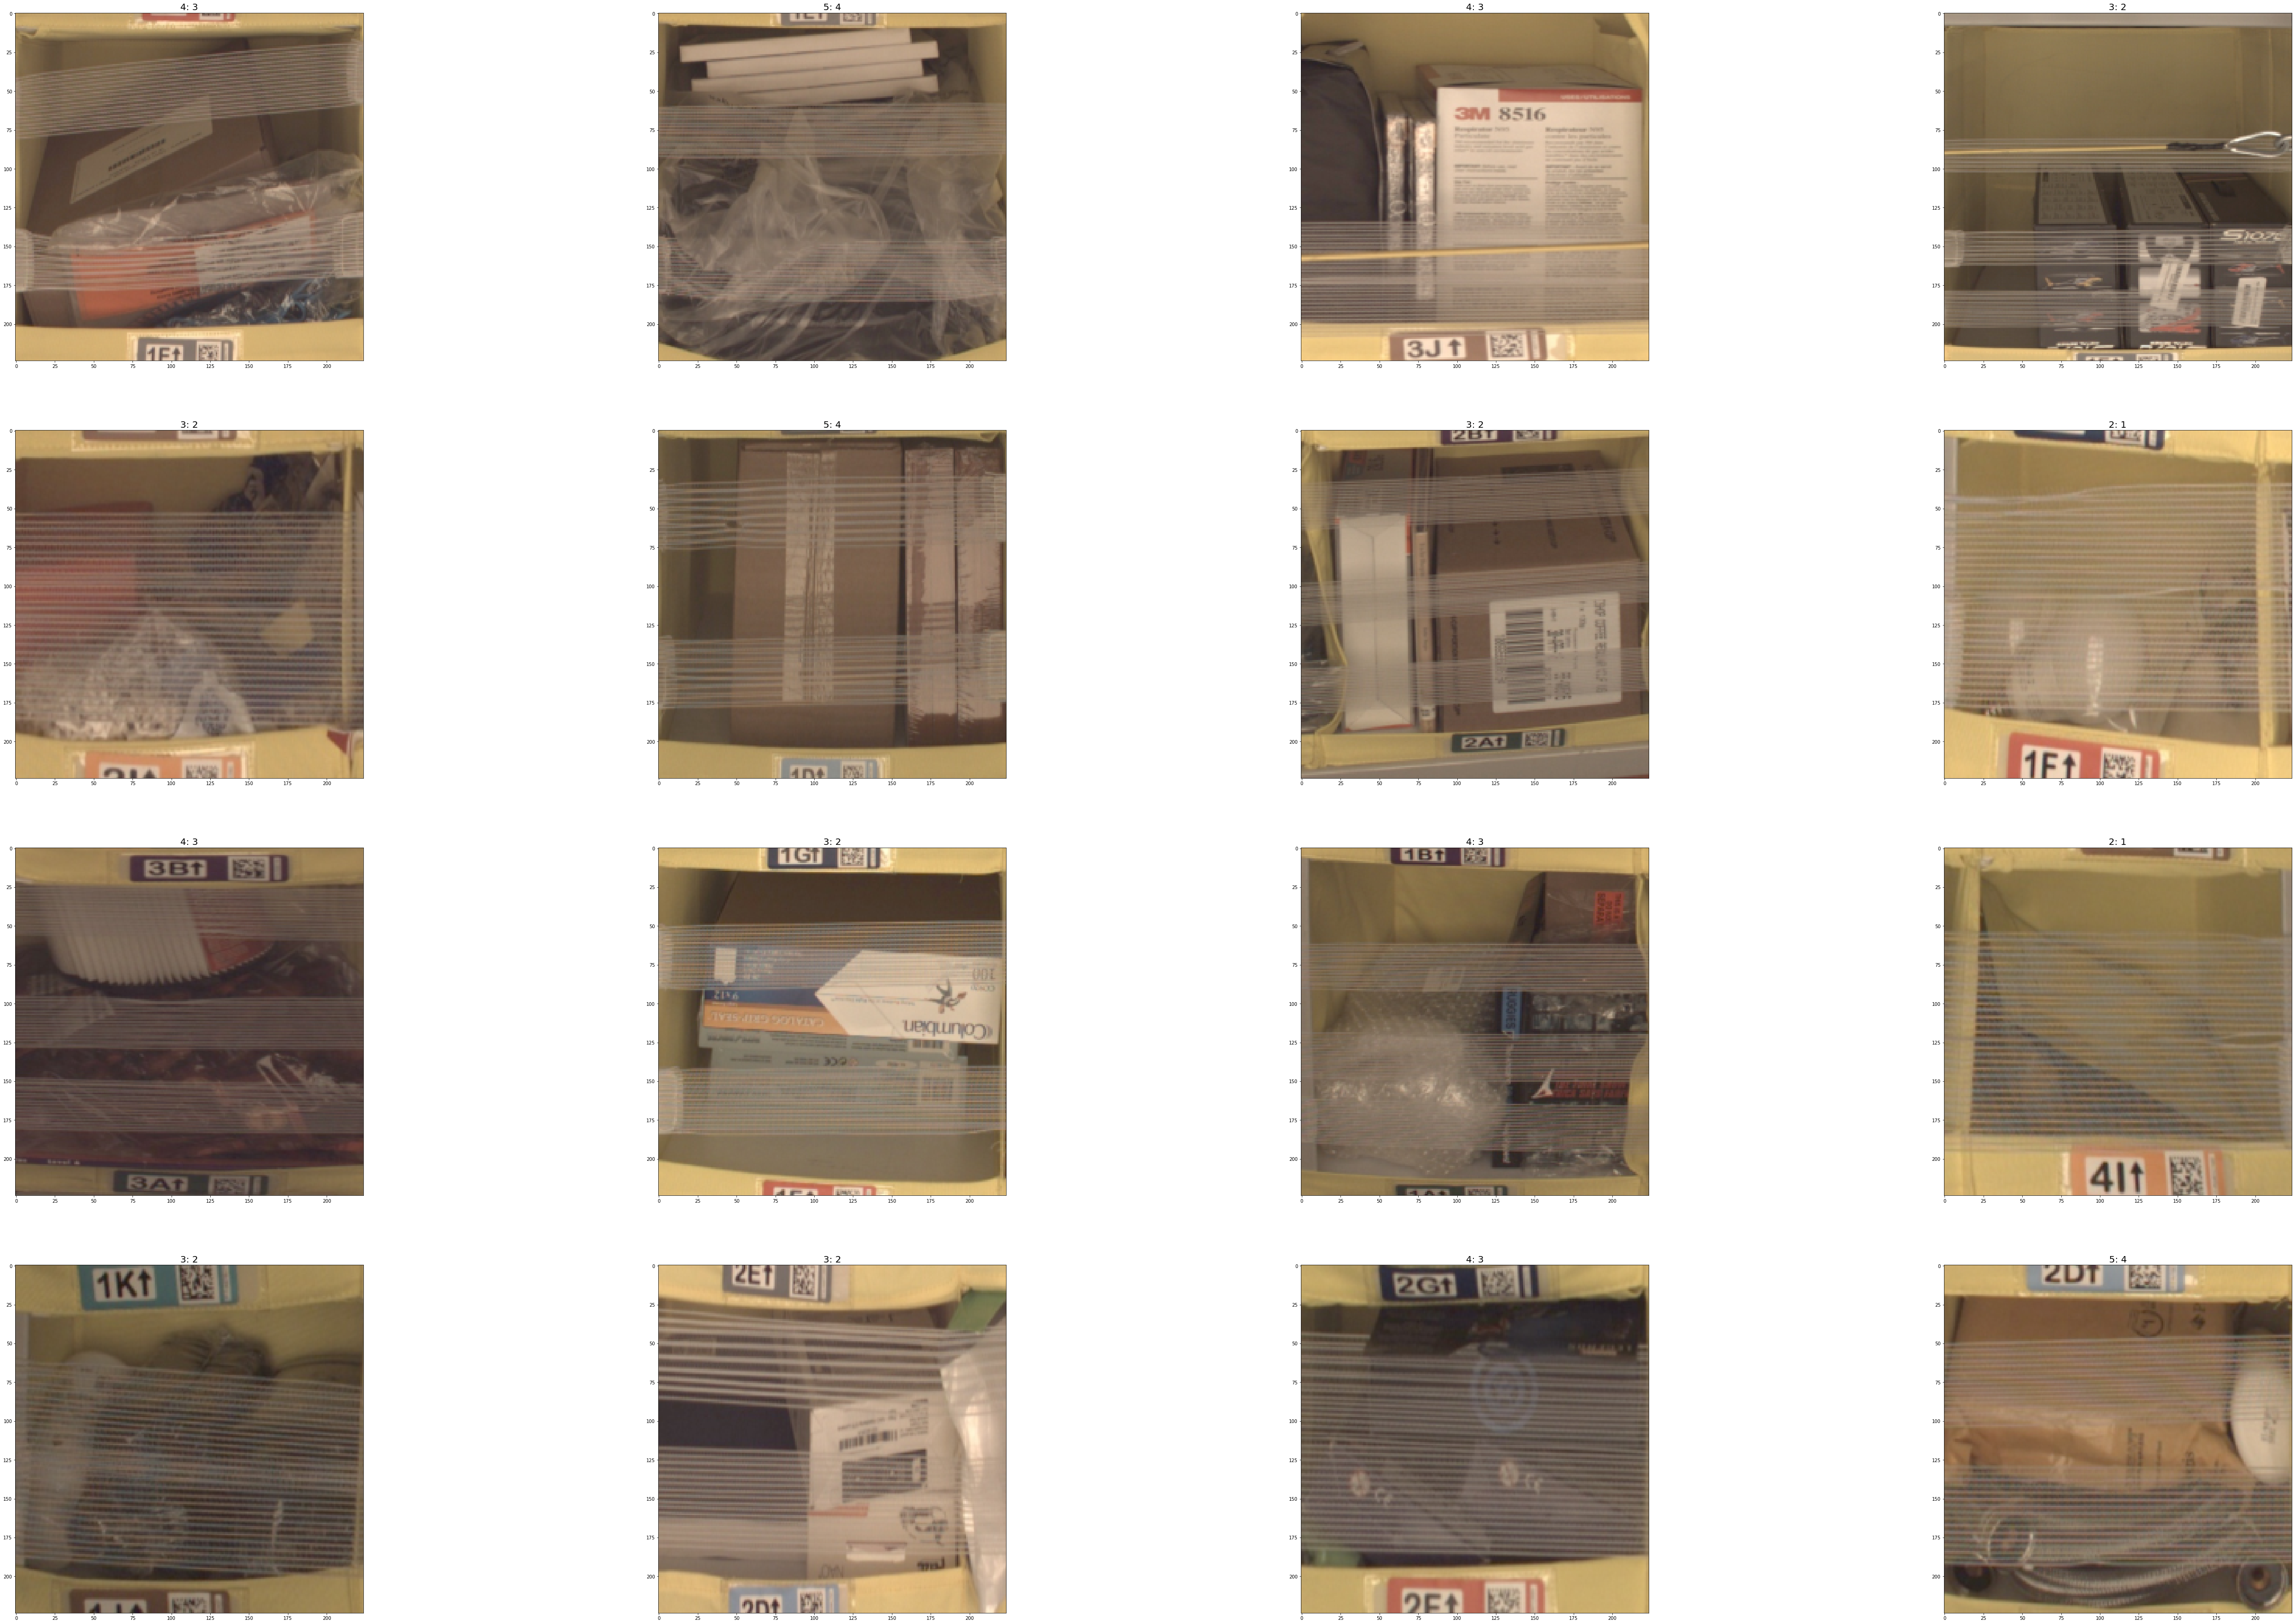

In [7]:
dataset.show_images()

In [8]:
model_list = ImagePredictor.list_models()
#model_list

In [9]:
models = ag.Categorical('coat_tiny', 'inception_v4', 'resnet18', 'resnet26', 'vgg16')

In [10]:
batch_sizes = ag.Categorical(32, 64, 128, 256)
learning_rates = ag.Real(0.001, 0.1, log=True)
hyperparameters={'model': models, 'batch_size': batch_sizes, 'lr': learning_rates, 'epochs': 3}

## First try

ImagePredictor sets accuracy as default eval_metric for classification problems.
Reset labels to [0, 1, 2, 3, 4]
Randomly split train_data into train[1881]/validation[210] splits.
No GPU detected/allowed, using most conservative search space.
Starting HPO experiments


modified configs(<old> != <new>): {
root.gpus            (0,) != ()
root.train.lr        0.01 != 0.001
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.img_cls.model   resnet101 != coat_tiny
root.misc.num_workers 4 != 2
root.misc.seed       42 != 90
}
Saved config to /root/SageMaker-Inventory-monitoring/2640d5a7/.trial_0/config.yaml
Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
modified configs(<old> != <new>): {
root.gpus            (0,) != ()
root.train.lr        0.01 != 0.015335192657991565
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.img_cls.model   resnet101 != coat_tiny
root.misc.num_workers 4 != 2
root.mis

Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Saving Training Curve in /root/SageMaker-Inventory-monitoring/2640d5a7/plot_training_curves.png


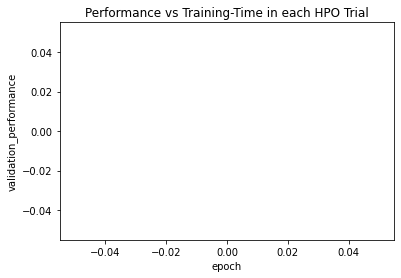

Finished, total runtime is 42.10 s


KeyError: 'estimator'

In [12]:
predictor = ImagePredictor()
predictor.fit(dataset, 
              time_limit=60*120, 
              hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={'num_trials': 2})